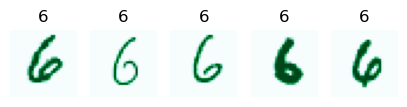

1 0.17814450146062477 0.05360495539068446 98.34666666666666 98.29
2 0.049895140472481815 0.04018010058815467 99.03833333333333 98.46
3 0.0354138162012633 0.031809592027312435 99.25833333333334 98.99
4 0.025477542998088 0.03082299881556259 99.35 98.87
5 0.01985317337851257 0.04282681544750312 98.99333333333334 98.53
6 0.01553739181858941 0.03441829151142521 99.62333333333333 99.0
7 0.012108636597253308 0.039998906316738095 99.59333333333333 98.9
8 0.010663495915277555 0.03446342050086039 99.78166666666667 99.12
9 0.008354437939043897 0.03404635089382456 99.78333333333333 99.05
10 0.008104134566779619 0.03373511392138555 99.79833333333333 99.07


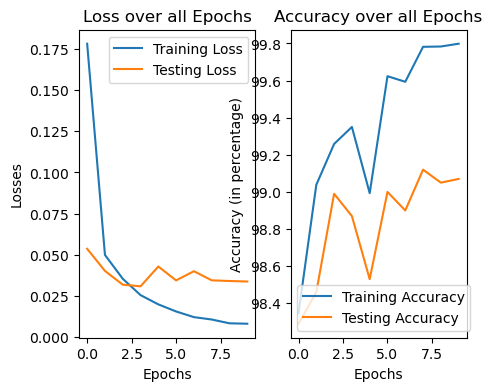

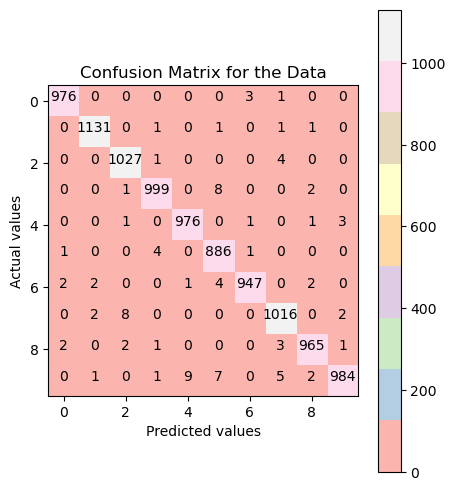

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as torch_optim
from sklearn.metrics import confusion_matrix
import numpy as np

trans = transforms.ToTensor()

traindata = torchvision.datasets.MNIST(root = './data', train = True, transform = trans, download = True)
testdata = torchvision.datasets.MNIST(root = './data', train = False, transform = trans, download = True)

trainloader = DataLoader(traindata, batch_size = 64, shuffle = True)
testloader = DataLoader(testdata, batch_size = 64, shuffle = False)

def showex(dig = 6, c = 5):
    s = 0
    plt.figure(figsize = (5, 2))
    for i, l in traindata:
        if l == dig:
            plt.subplot(1, c, s + 1)
            plt.imshow(i.squeeze(), cmap = 'BuGn')
            plt.title(str(l))
            plt.axis('off')
            s = s + 1
            if s == c:
                break
    plt.show()

showex(dig = 6, c = 5)

class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, kernel_size = 3)   
        self.p1 = nn.MaxPool2d(2, 2)                            
        self.c2 = nn.Conv2d(32, 64, kernel_size = 3)  
        self.p2 = nn.MaxPool2d(2, 2)                            
        self.f1 = nn.Linear(64 * 5 * 5, 128)
        self.f2 = nn.Linear(128, 10)

    def prediction(self, x):
        x = self.p1(F.relu(self.c1(x)))
        x = self.p2(F.relu(self.c2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.f1(x))
        x = self.f2(x)
        return x

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel = DigitCNN().to(dev)

loss_fn = nn.CrossEntropyLoss()
optim = torch_optim.Adam(mymodel.parameters(), lr = 0.001)

trainlossarr = []
testlossarr = []
trainaccuracyarr = []
testaccuracyarr = []

def get_accuracy(loader):
    t = 0
    correct = 0
    with torch.no_grad():
        for i, l in loader:
            i, l = i.to(dev), l.to(dev)
            output = mymodel.prediction(i)
            maxvalues, preds = torch.max(output, 1)
            t = t + l.size(0)
            correct = correct + (preds == l).sum().item()
    return 100 * correct/t

for epoch in range(10):
    mymodel.train()
    total_trainloss = 0

    for i, l in trainloader:
        i, l = i.to(dev), l.to(dev)
        optim.zero_grad()
        output = mymodel.prediction(i)
        loss = loss_fn(output, l)
        loss.backward()
        optim.step()
        total_trainloss = total_trainloss + loss.item()

    avg_trainloss = total_trainloss/len(trainloader)
    trainaccurate = get_accuracy(trainloader)
    testaccurate = get_accuracy(testloader)

    mymodel.eval()
    total_testloss = 0
    with torch.no_grad():
        for i, l in testloader:
            i, l = i.to(dev), l.to(dev)
            output = mymodel.prediction(i)
            loss = loss_fn(output, l)
            total_testloss = total_testloss + loss.item()

    avg_testloss = total_testloss/len(testloader)

    trainlossarr.append(avg_trainloss)
    testlossarr.append(avg_testloss)
    trainaccuracyarr.append(trainaccurate)
    testaccuracyarr.append(testaccurate)

    print(epoch + 1, avg_trainloss, avg_testloss, trainaccurate, testaccurate)

plt.figure(figsize = (5, 4))

plt.subplot(1, 2, 1)
plt.plot(trainlossarr, label = 'Training Loss')
plt.plot(testlossarr, label = 'Testing Loss')
plt.title('Loss over all Epochs')
plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainaccuracyarr, label = 'Training Accuracy')
plt.plot(testaccuracyarr, label = 'Testing Accuracy')
plt.title('Accuracy over all Epochs')
plt.ylabel('Accuracy (in percentage)')
plt.xlabel('Epochs')
plt.legend()

plt.show()

mymodel.eval()
preds_all = []
labels_all = []

with torch.no_grad():
    for i, l in testloader:
        i = i.to(dev)
        out = mymodel.prediction(i)
        _, preds = torch.max(out, 1)
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(l.numpy())

confmat = confusion_matrix(labels_all, preds_all)

plt.figure(figsize = (5, 6))
plt.imshow(confmat, cmap = 'Pastel1')
plt.title('Confusion Matrix for the Data')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')

for x in range(10):
    for y in range(10):
        plt.text(y, x, str(confmat[x][y]), ha = 'center')

plt.colorbar()
plt.show()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as torch_optim
from sklearn.metrics import confusion_matrix
import numpy as np

aug_trans = transforms.Compose([
    transforms.RandomRotation(degrees = 15),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.ToTensor()
])

traindata = torchvision.datasets.MNIST(root = './data', train = True, transform = aug_trans, download = True)
testdata = torchvision.datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor(), download = True)

trainloader = DataLoader(traindata, batch_size = 64, shuffle = True, num_workers = 2)
testloader = DataLoader(testdata, batch_size = 64, shuffle = False, num_workers = 2)

class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, kernel_size = 3)
        self.p1 = nn.MaxPool2d(2, 2)
        self.c2 = nn.Conv2d(32, 64, kernel_size = 3)
        self.p2 = nn.MaxPool2d(2, 2)
        self.f1 = nn.Linear(64 * 5 * 5, 128)
        self.f2 = nn.Linear(128, 10)

    def prediction(self, x):
        x = self.p1(F.relu(self.c1(x)))
        x = self.p2(F.relu(self.c2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.f1(x))
        x = self.f2(x)
        return x

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', dev) 

mymodel = DigitCNN().to(dev)
loss_fn = nn.CrossEntropyLoss()
optim = torch_optim.Adam(mymodel.parameters(), lr = 0.001)

trainlossarr = []
testlossarr = []
trainaccuracyarr = []
testaccuracyarr = []

def get_accuracy(loader):
    t = 0
    correct = 0
    with torch.no_grad():
        for i, l in loader:
            i, l = i.to(dev), l.to(dev)
            output = mymodel.prediction(i)
            maxvalues, preds = torch.max(output, 1)
            t = t + l.size(0)
            correct = correct + (preds == l).sum().item()
    return 100 * correct / t

for epoch in range(10):
    mymodel.train()
    total_trainloss = 0
    for i, l in trainloader:
        i, l = i.to(dev), l.to(dev)
        optim.zero_grad()
        output = mymodel.prediction(i)
        loss = loss_fn(output, l)
        loss.backward()
        optim.step()
        total_trainloss = total_trainloss + loss.item()
    avg_trainloss = total_trainloss / len(trainloader)
    trainaccurate = get_accuracy(trainloader)
    testaccurate = get_accuracy(testloader)
    mymodel.eval()
    total_testloss = 0
    with torch.no_grad():
        for i, l in testloader:
            i, l = i.to(dev), l.to(dev)
            output = mymodel.prediction(i)
            loss = loss_fn(output, l)
            total_testloss = total_testloss + loss.item()
    avg_testloss = total_testloss / len(testloader)
    trainlossarr.append(avg_trainloss)
    testlossarr.append(avg_testloss)
    trainaccuracyarr.append(trainaccurate)
    testaccuracyarr.append(testaccurate)
    print(epoch + 1, avg_trainloss, avg_testloss, trainaccurate, testaccurate)

plt.figure(figsize = (5, 4))

plt.subplot(1, 2, 1)
plt.plot(trainlossarr, label = 'Training Loss')
plt.plot(testlossarr, label = 'Testing Loss')
plt.title('Loss over all Epochs')
plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainaccuracyarr, label = 'Training Accuracy')
plt.plot(testaccuracyarr, label = 'Testing Accuracy')
plt.title('Accuracy over all Epochs')
plt.ylabel('Accuracy (in percentage)')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show(block = False)  

mymodel.eval()
preds_all = []
labels_all = []

with torch.no_grad():
    for i, l in testloader:
        i = i.to(dev)
        out = mymodel.prediction(i)
        maxvalues, preds = torch.max(out, 1)
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(l.numpy())

confmat = confusion_matrix(labels_all, preds_all)

plt.figure(figsize = (5, 6))
plt.imshow(confmat, cmap = 'Pastel1')
plt.title('Confusion Matrix for the Data')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')

for x in range(10):
    for y in range(10):
        plt.text(y, x, str(confmat[x][y]), ha = 'center')

plt.colorbar()

plt.show(block = False)